In [1]:
!pip3 install -q nomkl

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


2024-05-18 14:47:46.444176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 14:47:46.444278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 14:47:46.562400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 2


In [4]:
# Define your dataset folder path
dataset_path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'

In [5]:
# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        # Open and check if the image can be loaded
        Image.open(file_path)
        return True
    except (IOError, SyntaxError):
        # Invalid image file
        return False

In [6]:

# Filter out valid images and create a list of file paths and labels
file_paths = []
labels = []


for label in ['Cat', 'Dog']:
    label_folder = os.path.join(dataset_path, label)
    for file_name in os.listdir(label_folder):
        file_path = os.path.join(label_folder, file_name)
        if is_valid_image(file_path):
            file_paths.append(file_path)
            labels.append('Cat' if label == 'Cat' else 'Dog')  # Convert label to string

# Convert lists to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)



In [7]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)




In [8]:
# Define data generators for training and testing
batch_size = 64

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_file_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(28, 28),  # adjust target_size as needed
    batch_size=batch_size,
    class_mode='categorical',  # binary classification
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_file_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(28, 28),  # adjust target_size as needed
    batch_size=batch_size,
    class_mode='categorical',  # binary classification
    shuffle=False)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [10]:
for batch in test_generator:
    # Extract the first image and label from the batch
    image = batch[0][0]  # First image in the batch
    label = batch[1][0]  # Corresponding label

    # Print the label (0 for Cat, 1 for Dog)
    print(label)
    
    break



[0. 1.]


In [11]:
class_indices = test_generator.class_indices

# Invert the dictionary to map indices to class names
class_names_mapping = {v: k for k, v in class_indices.items()}

# Check which class is mapped to class 0 and which to class 1
class_0 = class_names_mapping[0]
class_1 = class_names_mapping[1]

print(f"Class 0 is mapped to '{class_0}'")
print(f"Class 1 is mapped to '{class_1}'")


Class 0 is mapped to 'Cat'
Class 1 is mapped to 'Dog'


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Dropout
from tensorflow.keras.initializers import RandomNormal, Constant

In [13]:
def custom_cnn(num_classes=2):
    model = Sequential()

    # Block 1
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output before adding FC layers
    model.add(Flatten())

    # Fully Connected (FC) layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [14]:
# Create an instance of the CustomCNN model
model = custom_cnn()

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,178 (805.38 KB)

 Trainable params: 206,178 (805.38 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath for saving the best model
checkpoint_filepath = 'best_model.keras'

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # monitor validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [17]:

# Train the model
epochs = 20

# Calculate steps per epoch for training
steps_per_epoch = train_generator.samples // batch_size

# Calculate validation steps for validation
validation_steps = test_generator.samples // batch_size

# Train the model with the callback
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]  # Pass the ModelCheckpoint callback
)

Epoch 1/20
  3/312 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.4714 - loss: 0.8142

I0000 00:00:1716043911.778899     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716043911.796217     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/312 ━━━━━━━━━━━━━━━━━━━━ 1:00 222ms/step - accuracy: 0.4995 - loss: 0.7340

W0000 00:00:1716043919.891504     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


306/312 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5646 - loss: 0.6819

W0000 00:00:1716043954.643201     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.69211, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - accuracy: 0.5658 - loss: 0.6811 - val_accuracy: 0.6921 - val_loss: 0.5895
Epoch 2/20
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 0.5807
Epoch 2: val_accuracy did not improve from 0.69211
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.5807 - val_accuracy: 0.5000 - val_loss: 0.7504
Epoch 3/20


W0000 00:00:1716043964.898043     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


306/312 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6969 - loss: 0.5823
Epoch 3: val_accuracy improved from 0.69211 to 0.70593, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.6972 - loss: 0.5820 - val_accuracy: 0.7059 - val_loss: 0.5604
Epoch 4/20
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.5030
Epoch 4: val_accuracy did not improve from 0.70593
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.7500 - loss: 0.5030 - val_accuracy: 0.5000 - val_loss: 0.8138
Epoch 5/20
306/312 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7468 - loss: 0.5253
Epoch 5: val_accuracy improved from 0.70593 to 0.75060, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.7467 - loss: 0.5253 - val_accuracy: 0.7506 - val_loss: 0.5074
Epoch 6/20
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.4153
Epoch 6: val_accuracy did not improve from 0.75060
312/312 ━━━━━━━━━━━━━━━━━

In [18]:
model = tf.keras.models.load_model(checkpoint_filepath)

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

 1/79 ━━━━━━━━━━━━━━━━━━━━ 50s 646ms/step - accuracy: 0.8281 - loss: 0.4601

W0000 00:00:1716044410.230706     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.7837 - loss: 0.4592
Test accuracy: 0.7797999978065491


W0000 00:00:1716044421.785508     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [20]:
model.export("test", "tf_saved_model")

Saved artifact at 'test'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139654827763040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654827138864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654822220848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654822215744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654822229120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654822231584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654822807504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654822811552: TensorSpec(shape=(), dtype=tf.resource, name=None)


# **Post Training Quantization**


In [21]:
def representative_dataset():
    counter = 0
    for image_batch, labels_batch in test_generator:
        yield [image_batch]
        counter += 1
        if counter >= 10:
            break


In [22]:
representative_dataset()

<generator object representative_dataset at 0x7f03cc18cf90>

In [23]:
import tensorflow as tf

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model("test")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops =[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type  = tf.float32

converter.inference_output_type = tf.int8

In [25]:

quantiz_model = converter.convert()

open("PTQModel.tflite", "wb").write(quantiz_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 9, Total Ops 20, % non-converted = 45.00 %
 * 9 ARITH ops

- arith.constant:    9 occurrences  (f32: 8, i32: 1)



  (f32: 2)
  (f32: 2)
  (f32: 2)
  (f32: 1)
  (f32: 1)
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: INT8


212224

In [26]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/PTQModel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Output Data : [[ 114 -114]]
Predicted class: 0
Predicted class name: Cat


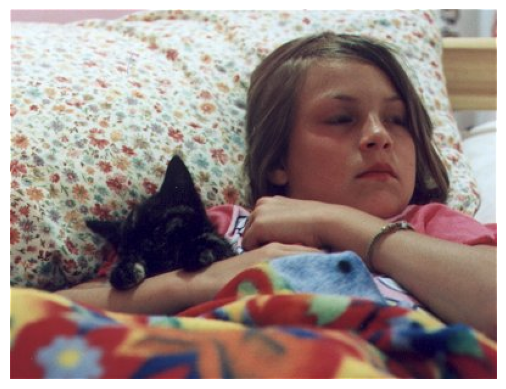

In [27]:
# Prepare the image
def preprocess_image(image_path, input_shape):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((input_shape[1], input_shape[2]))
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = img / 128 - 1
    return img

# Load and preprocess the image
image_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/6.jpg"
input_shape = input_details[0]['shape']
image = preprocess_image(image_path, input_shape)

# Set the tensor
interpreter.set_tensor(input_details[0]['index'], image)

# Run the inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])
# Get predicted label
predicted_label = np.argmax(output_data, axis=1)[0]


# Print the predicted label
print(f"Output Data : {output_data}")
print(f"Predicted class: {predicted_label}")
predicted_class_name = class_names_mapping[predicted_label]
print(f"Predicted class name: {predicted_class_name}")


# Display the image
import matplotlib.pyplot as plt

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


# **QAT : Quantization Aware Training**

In [28]:
! pip install -q tensorflow-model-optimization


In [29]:
from tensorflow_model_optimization.python.core.keras.compat import keras as k

In [30]:
def qat_custom_cnn(num_classes=2):
    model = k.Sequential()

    # Block 1
    model.add(k.layers.Conv2D(8, (3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 3)))
    model.add(k.layers.BatchNormalization())
    model.add(k.layers.Activation('relu'))
    model.add(k.layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(k.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same'))
    model.add(k.layers.BatchNormalization())
    model.add(k.layers.Activation('relu'))
    model.add(k.layers.MaxPooling2D((2, 2)))

    # Flatten the output before adding FC layers
    model.add(k.layers.Flatten())

    # Fully Connected (FC) layers
    model.add(k.layers.Dense(64, activation='relu'))
    model.add(k.layers.Dropout(0.5))  # Add dropout for regularization
    model.add(k.layers.Dense(num_classes, activation='softmax'))

    return model


In [31]:
model = qat_custom_cnn()

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         224       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 8)         32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 16)        6

In [33]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28, 3)         3         
 yer)                                                            
                                                                 
 quant_conv2d (QuantizeWrap  (None, 28, 28, 8)         241       
 perV2)                                                          
                                                                 
 quant_batch_normalization   (None, 28, 28, 8)         33        
 (QuantizeWrapperV2)                                             
                                                                 
 quant_activation (Quantize  (None, 28, 28, 8)         3         
 WrapperV2)                                                      
                                                                 
 quant_max_pooling2d (Quant  (None, 14, 14, 8)         1

In [34]:

# Train the model
epochs = 10

# Calculate steps per epoch for training
steps_per_epoch = np.ceil(train_generator.samples / batch_size)

# Calculate validation steps for validation
validation_steps = np.ceil(test_generator.samples / batch_size)

# Train the quantization-aware model
q_aware_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps
)

Epoch 1/10
313/313 [==============================] - 77s 171ms/step - loss: 0.6938 - accuracy: 0.5388 - val_loss: 0.6708 - val_accuracy: 0.5566
Epoch 2/10
313/313 [==============================] - 54s 173ms/step - loss: 0.6127 - accuracy: 0.6621 - val_loss: 0.5840 - val_accuracy: 0.6844
Epoch 3/10
313/313 [==============================] - 51s 164ms/step - loss: 0.5794 - accuracy: 0.6951 - val_loss: 0.5571 - val_accuracy: 0.7024
Epoch 4/10
313/313 [==============================] - 50s 160ms/step - loss: 0.5554 - accuracy: 0.7130 - val_loss: 0.5822 - val_accuracy: 0.6936
Epoch 5/10
313/313 [==============================] - 48s 155ms/step - loss: 0.5314 - accuracy: 0.7300 - val_loss: 0.5405 - val_accuracy: 0.7288
Epoch 6/10
313/313 [==============================] - 49s 157ms/step - loss: 0.5203 - accuracy: 0.7400 - val_loss: 0.5234 - val_accuracy: 0.7402
Epoch 7/10
313/313 [==============================] - 51s 163ms/step - loss: 0.5109 - accuracy: 0.7458 - val_loss: 0.5164 - val_ac

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 1, Total Ops 22, % non-converted = 4.55 %
 * 1 ARITH ops

- arith.constant:    1 occurrences  (i32: 1)



  (uq_8: 2)
  (f32: 1)
  (uq_8: 2)
  (uq_8: 2)
  (uq_8: 4, uq_32: 4)
  (uq_8: 1)
  (uq_8: 1)
  (uq_8: 1)


In [36]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


(1, 28, 28, 3)
Output Data : [[0.984375 0.015625]]
Predicted class: 0
Predicted class name: Cat


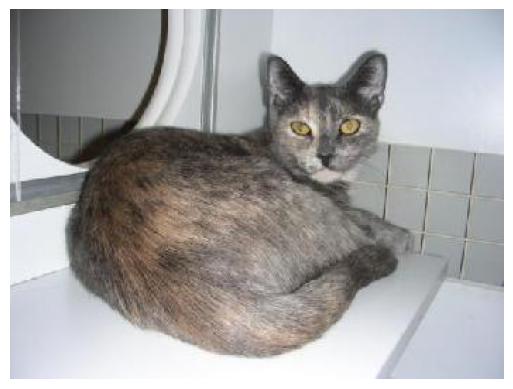

In [40]:
# Prepare the image
def preprocess_image(image_path, input_shape):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((input_shape[1], input_shape[2]))
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = img / 128 - 1
    print(img.shape)
    return img

# Load and preprocess the image
image_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/30.jpg"
input_shape = input_details[0]['shape']
image = preprocess_image(image_path, input_shape)

# Set the tensor
interpreter.set_tensor(input_details[0]['index'], image)


# Run the inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])
# Get predicted label
predicted_label = np.argmax(output_data, axis=1)[0]

# Print the predicted label
print(f"Output Data : {output_data}")
print(f"Predicted class: {predicted_label}")
predicted_class_name = class_names_mapping[predicted_label]
print(f"Predicted class name: {predicted_class_name}")


# Display the image
import matplotlib.pyplot as plt

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [38]:
# Specify the file path to save the model
tflite_model_path = "QATModel.tflite"

# Write the model to the file
with open(tflite_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"Quantized TensorFlow Lite model saved to: {tflite_model_path}")


Quantized TensorFlow Lite model saved to: QATModel.tflite
